In [2]:
#First, import the libraries needed, we'll be using keras/tensorflow library for calculation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

#This is used only for ipynb notebook environments allowing import of functions from the appended directory
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier")

#The actual model is built in a separate file "model_build.py" and imported into this main script
#The file "image_utils.py" contains utility functions for image and dataset preprocessing
from image_utils import process_dataset
from model_build import build_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Specifying the directory of my dataset(CXR images), train/val/test sets are grouped in separate folders
#Under each folder, there will be subfolders "NORMAL" and "PNEUMONIA", containing the respective images
train_normal_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/train/NORMAL/"
train_pneumonia_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/train/PNEUMONIA/"

val_normal_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/val/NORMAL/"
val_pneumonia_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/val/PNEUMONIA/"

test_normal_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/test/NORMAL/"
test_pneumonia_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/test/PNEUMONIA/"

In [4]:
#We'll use glob to pick up the jpeg extension of the images in each of the directories
#This will give us the list of "dir/images" in each directories
train_normal_images = glob.glob(train_normal_path + "*jpeg")
train_pneumonia_images = glob.glob(train_pneumonia_path + "*jpeg")

val_normal_images = glob.glob(val_normal_path + "*jpeg")
val_pneumonia_images = glob.glob(val_pneumonia_path + "*jpeg")

test_normal_images = glob.glob(test_normal_path + "*jpeg")
test_pneumonia_images = glob.glob(test_pneumonia_path + "*jpeg")

In [5]:
#We will try to construct a pandas dataframe thus we need to prepare a list of train/val/test datasets for conversion
#The dataframe will contain 2 columns: 1st column "Images", 2nd column "Labels"
train_list = []
val_list = []
test_list = []

for x in train_normal_images:
    train_list.append([x,0])
for x in train_pneumonia_images:
    train_list.append([x,1])

for x in val_normal_images:
    val_list.append([x,0])
for x in val_pneumonia_images:
    val_list.append([x,1])
    
for x in test_normal_images:
    test_list.append([x,0])
for x in test_pneumonia_images:
    test_list.append([x,1])
    
random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

In [6]:
train_df = pd.DataFrame(train_list, columns = ["Images","Labels"])
val_df = pd.DataFrame(val_list, columns = ["Images", "Labels"])
test_df = pd.DataFrame(test_list, columns = ["Images", "Labels"])

In [7]:
#Example of dataframe showing the first 5 entries
train_df.head()

,Images,Labels
0,/content/drive/My Drive/Colab Notebooks/DeepLe...,1
1,/content/drive/My Drive/Colab Notebooks/DeepLe...,1
2,/content/drive/My Drive/Colab Notebooks/DeepLe...,1
3,/content/drive/My Drive/Colab Notebooks/DeepLe...,0
4,/content/drive/My Drive/Colab Notebooks/DeepLe...,1


In [10]:
#You can try to plot the proportion of labels (1,0) in each set
#sns.countplot(train_df.Labels)
#sns.countplot(val_df.Labels)
#sns.countplot(test_df.Labels)

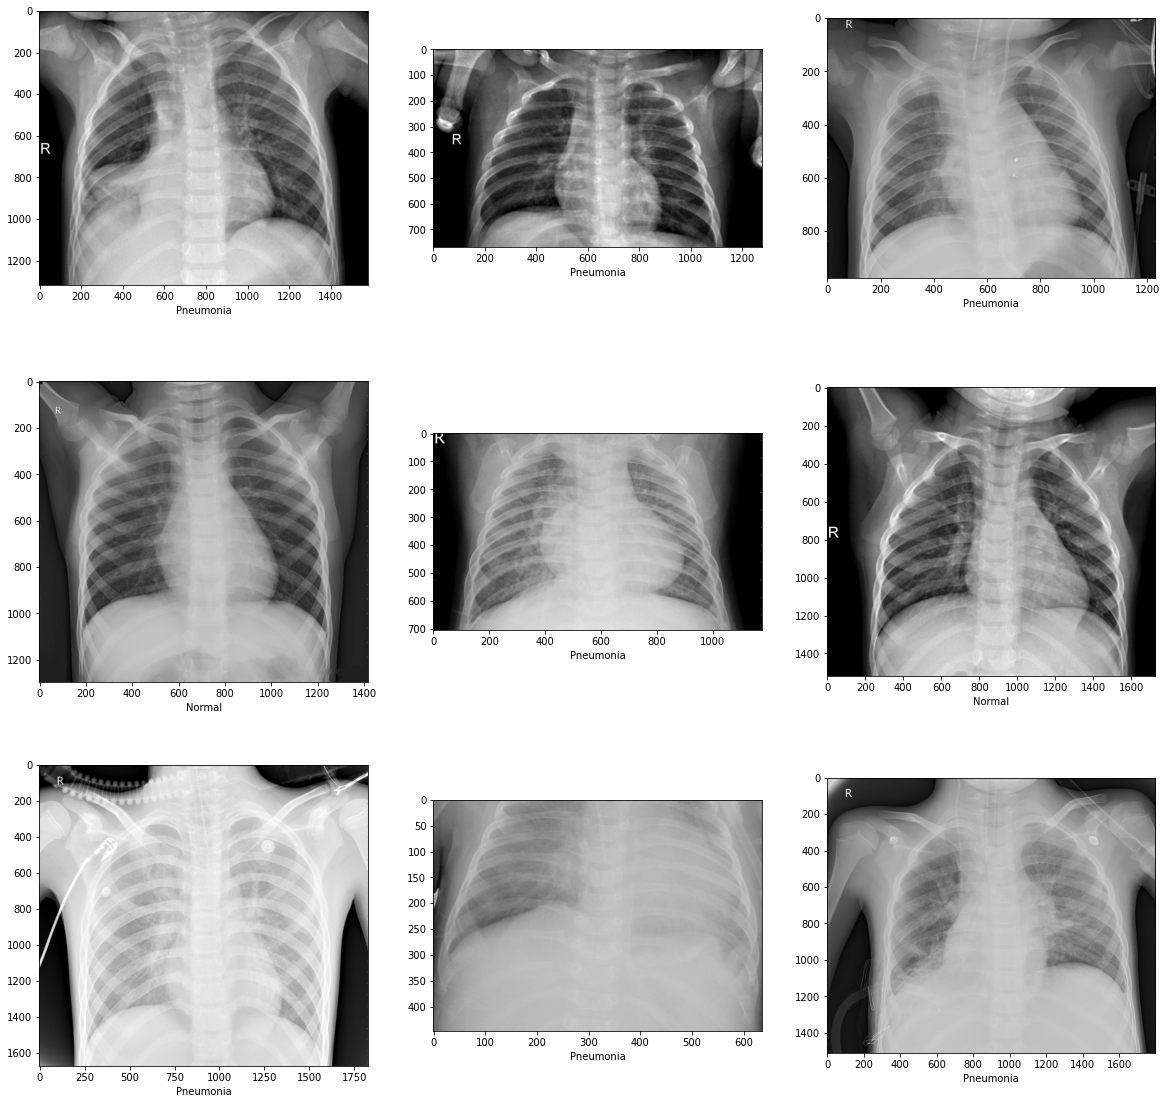

In [8]:
#Lets plot some images in the dataset using the dataframe we created
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.grid(False)
    img = plt.imread(train_df['Images'][i])
    plt.imshow(img, cmap='gray')
    if train_df['Labels'][i]==1:
        plt.xlabel("Pneumonia")
    else:
        plt.xlabel("Normal")  
plt.show()

In [13]:
#We will use the process_dataset() function from "image_utils.py" to process the image dataset into numpy arrays
#For more information, please check "image_utils.py"
train_X, train_Y = process_dataset(train_df)
val_X, val_Y = process_dataset(val_df)
test_X, test_Y = process_dataset(test_df)

In [11]:
#Since loading and processing data from Google drive takes eternity, we will load preprocessed numpy matrices that hold image data
#You don't need to run the above cell if you plan to use preprocessed data to cut time
#Please pass the correct directory of the .npy files to your own needs
train_X = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/train_X.npy")
train_Y = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/train_Y.npy")
val_X = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/val_X.npy")
val_Y = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/val_Y.npy")
test_X = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/test_X.npy")
test_Y = np.load("/content/drive/My Drive/Colab Notebooks/DeepLearning/Test4 CXR_Pneumonia_Classifier/test_Y.npy")
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(test_X.shape)
print(test_Y.shape)


(5216, 224, 224, 1)
(5216,)
(16, 224, 224, 1)
(16,)
(624, 224, 224, 1)
(624,)


In [12]:
#Using data augmentation on the training set(train_X) to achieve better performance given our small dataset size
#Small dataset sizes are common in medical and health care settings
data_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

data_aug.fit(train_X)

In [13]:
#Importing build_model function from "model_build.py"
#Please check summary below or "model_build.py"
model = build_model(train_X.shape[1:])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       3144      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 16)        3216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        4

In [14]:
#Compiling the model, setting our loss function, choosing our optimizer and metrics
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [15]:
#Lets train our model using the above settings
#Here, test data (test_X, test_Y) is used for validation because validation set (val_X, val_Y) has a vary small dataset
#Please see kaggle site: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia for dataset reference
model.fit(data_aug.flow(train_X, train_Y, batch_size = 32), validation_data = (test_X, test_Y), epochs = 25)

Epoch 1/25
163/163 [==============================] - 19s 117ms/step - loss: 0.5487 - accuracy: 0.7510 - val_loss: 0.5831 - val_accuracy: 0.6506
Epoch 2/25
163/163 [==============================] - 19s 114ms/step - loss: 0.4003 - accuracy: 0.8104 - val_loss: 0.5079 - val_accuracy: 0.7500
Epoch 3/25
163/163 [==============================] - 19s 115ms/step - loss: 0.2558 - accuracy: 0.8894 - val_loss: 0.4016 - val_accuracy: 0.8237
Epoch 4/25
163/163 [==============================] - 19s 115ms/step - loss: 0.2187 - accuracy: 0.9070 - val_loss: 0.3831 - val_accuracy: 0.8413
Epoch 5/25
163/163 [==============================] - 19s 115ms/step - loss: 0.1991 - accuracy: 0.9189 - val_loss: 0.3955 - val_accuracy: 0.8413
Epoch 6/25
163/163 [==============================] - 19s 114ms/step - loss: 0.1936 - accuracy: 0.9254 - val_loss: 0.2954 - val_accuracy: 0.8830
Epoch 7/25
163/163 [==============================] - 19s 114ms/step - loss: 0.1905 - accuracy: 0.9241 - val_loss: 0.2867 - val_ac

In [16]:
model.evaluate(test_X, test_Y)

20/20 [==============================] - 0s 15ms/step - loss: 0.2509 - accuracy: 0.9215


[0.2509370446205139, 0.9214743375778198]

In [18]:
#Prediction using test set
preds = model.predict_classes(test_X)
preds = np.array(preds)
preds[0:10]
print(classification_report(test_Y,preds))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       234
           1       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624



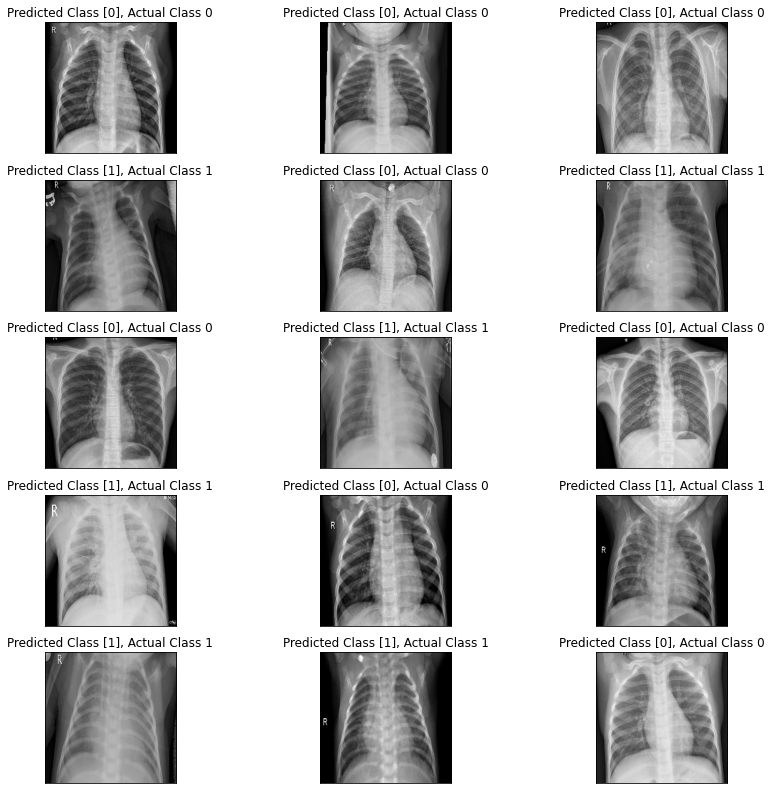

In [34]:
#Plotting the first few predictions
plt.figure(figsize = (14,14))
for c in range(15):
    plt.subplot(5,3,c+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_X[c].reshape(224,224), cmap="gray")
    plt.title("Predicted Class {}, Actual Class {}".format(preds[c], test_Y[c]))

# Footnotes

- The achieved accuracy with current hyperparameters and CNN
architecture is 92% as observed on the test set.
- However, slightly better accuracy can be attained by exploring different hyperparameters or, possibly different model architecture.

# Sincere References go to: 
- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- https://www.kaggle.com/sumitsingh20pneumonia-predictions-2-methods
- https://www.coursera.org/learn/convolutional-neural-networks?

